In [2]:
#@title Importing Libraries
import time
import os
import cv2
import numpy as np
from skimage import transform as tf
import random
import glob
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.mobilenet_v2 import MobileNetV2
from keras import optimizers, regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.preprocessing import image
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model


Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
DIR = "/content/drive/My Drive/ColabNotebooks/TM imagesCNN/"

In [160]:
diseases = os.listdir(DIR)
print(diseases)

['Acute', 'Glue ear', 'Normal Ear', 'Otomycosis', 'Safe CSOM', 'Others']


In [161]:
for disease in diseases:
        # get a list of subdirectories that start with this character
        directory_list = (glob.glob("{}/*".format(DIR, disease)))
print(directory_list)

['/content/drive/My Drive/ColabNotebooks/TM imagesCNN/Acute', '/content/drive/My Drive/ColabNotebooks/TM imagesCNN/Glue ear', '/content/drive/My Drive/ColabNotebooks/TM imagesCNN/Normal Ear', '/content/drive/My Drive/ColabNotebooks/TM imagesCNN/Otomycosis', '/content/drive/My Drive/ColabNotebooks/TM imagesCNN/Safe CSOM', '/content/drive/My Drive/ColabNotebooks/TM imagesCNN/Others']


In [162]:
#@title Dataset Stats
def dataset_stats():
    
    # This is an array with the all the diseases available in the directory.

    diseases = os.listdir(DIR)
    
    # dictionary where we will store the stats
    stats = []
    
    for disease in diseases:
        # get a list of subdirectories that start with this character
        directory_list = sorted(glob.glob("{}/*".format(DIR, disease)))
        
    for sub_directory in directory_list:
        file_names = [file for file in os.listdir(sub_directory)]
        file_count = len(file_names)
        sub_directory_name = os.path.basename(sub_directory)
        stats.append({ "Code": sub_directory_name[:sub_directory_name.find('-')],
                        "Image count": file_count, 
                       "Folder name": os.path.basename(sub_directory),
                        "File names": file_names})

    
    df = pd.DataFrame(stats)
    
    return df

In [176]:
import imgaug.augmenters as iaa
class re_data:
    def read_path():
        l=[]
        for name in glob.glob('./images/*.jpg'):
            l.append(name)
        return l
            
    def Read_data(data,l):
        images =[]
        path='./images/'
        for img in data:
            path=path+img
            if path in l:
                im=imread(path)
                images.append(im)
            path='./images/'
        return np.array(images)
    
    def plot_image(images, captions=None, cmap=None ):
        f, axes = plt.subplots(1, len(images), sharey=True)
        f.set_figwidth(15)
        for ax,image in zip(axes, images):
            ax.imshow(image, cmap)
            
    def flip_image(image):
        return np.fliplr(image)
    
    def shear_image(image):
        shift_x, shift_y = image.shape[0]/2, image.shape[1]/2
        matrix_to_topleft = tf.SimilarityTransform(translation=[-shift_x, -shift_y])
        matrix_to_center = tf.SimilarityTransform(translation=[shift_x, shift_y])
        shear_transforms = tf.AffineTransform(shear=np.deg2rad(45))
        shear_matrix = matrix_to_topleft + shear_transforms + matrix_to_center
        shear_image = tf.warp(image, shear_matrix)
        return shear_image
        
    def Gray_image(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray=tf.resize(gray,(224,224,3),anti_aliasing=False)
        gaussian = cv2.GaussianBlur(gray,(3,3),0)
        return gaussian
        
    def rotate_45(image):
        # rotation
        shift_x, shift_y = image.shape[0]/2, image.shape[1]/2
        matrix_to_topleft = tf.SimilarityTransform(translation=[-shift_x, -shift_y])
        matrix_to_center = tf.SimilarityTransform(translation=[shift_x, shift_y])
        rot_transforms =  tf.AffineTransform(rotation=np.deg2rad(45))
        rot_matrix = matrix_to_topleft + rot_transforms + matrix_to_center
        rot_image = tf.warp(image, rot_matrix)
        return rot_image
        
    def Zoom_out(image):
        # scaling 
        shift_x, shift_y = image.shape[0]/2, image.shape[1]/2
        matrix_to_topleft = tf.SimilarityTransform(translation=[-shift_x, -shift_y])
        matrix_to_center = tf.SimilarityTransform(translation=[shift_x, shift_y])
        scale_transforms = tf.AffineTransform(scale=(2, 2))
        scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
        scale_image_zoom_out = tf.warp(image, scale_matrix)
        return scale_image_zoom_out
        
    
    def Zoom_in(image):
        shift_x, shift_y = image.shape[0]/2, image.shape[1]/2
        matrix_to_topleft = tf.SimilarityTransform(translation=[-shift_x, -shift_y])
        matrix_to_center = tf.SimilarityTransform(translation=[shift_x, shift_y])
        scale_transforms = tf.AffineTransform(scale=(0.5, 0.5))
        scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
        scale_image_zoom_in = tf.warp(image, scale_matrix)
        return scale_image_zoom_in
        
    def Translation(image):
        # translation
        transaltion_transforms = tf.AffineTransform(translation=(50, 50))
        translated_image = tf.warp(image, transaltion_transforms)
        return translated_image
        
    def Contrast(image):
        contrast=iaa.GammaContrast(gamma=2.0)
        contrast_image =contrast.augment_image(image)
        return contrast_image

In [164]:
# Show codes with their folder names and image counts
dataset = dataset_stats().set_index("Code")
dataset[["Folder name", "Image count"]]
type(dataset)

pandas.core.frame.DataFrame

In [165]:
dataset

,Image count,Folder name,File names
Code,,,
Acut,26,Acute,"[20180101000041-H0000001.JPG, 20180101000044-H..."
Glue ea,16,Glue ear,"[20180101000044-H0000004.JPG, 20180101000037-H..."
Normal Ea,90,Normal Ear,"[20180101000033-H0000003.JPG, 20180101000033-H..."
Other,29,Others,"[19700101000044-H0000003.jpg, 20180101000043-H..."
Otomycosi,21,Otomycosis,"[20180101000040-H0000001.JPG, 20180101000043-H..."
Safe CSO,56,Safe CSOM,"[20180101000035-H0000001.JPG, 20180101000037-H..."


In [147]:
#@title Load Images
# Function returns an array of images whoose filenames start with a given set of characters
# after resizing them to 224 x 224

def load_images(codes):
    
    # Define empty arrays where we will store our images and labels
    images = []
    labels = []
    
    for code in codes:
        # get the folder name for this code
        folder_name = dataset.loc[code]["Folder name"]
        
        for file in dataset.loc[code]["File names"]:                 
            # build file path
            file_path = os.path.join(DIR, folder_name, file)
        
            # Read the image
            image = cv2.imread(file_path)
            
            # #Removing black regions
            # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # mask = gray>100
            # image = image[np.ix_(mask.any(1),mask.any(0))]

            # Resize it to 224 x 224
            # image = cv2.resize(image, (224,224))

            #Convert it from BGR to RGB so we can plot them later (because openCV reads images as BGR)
            # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Now we add it to our array
            images.append(image)
            labels.append(code)
            
            #Now save images
            # cv2.imwrite(file_path,image)

    return images, labels

In [178]:
def Load_Images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)

    return np.array(images)

In [183]:
pathfolder = DIR+"Glue ear/"
df= Load_Images_from_folder(pathfolder)
# df= np.array([df])
df.shape

(16, 224, 224, 3)

In [184]:
from matplotlib.image import imsave
X_aug=[]
y_aug=[]
name='aug'
path = '/content/drive/My Drive/ColabNotebooks/Aug_Images/GlueEar/'
for i in range(len(df)):
        img=df[i]
        X_aug.append(img)
        imsave(path+name+str(i)+'.jpg', img)
        
        img_flip = re_data.flip_image(df[i])
        X_aug.append(img_flip)
        imsave(path+name+'_flip'+str(i)+'.jpg', img_flip)

        img_shear=re_data.shear_image(df[i])
        X_aug.append(img_shear)
        imsave(path+name+'_shear'+str(i)+'.jpg', img_shear)
    
        gray=re_data.Gray_image(df[i])
        X_aug.append(gray)
        imsave(path+name+'_gray'+str(i)+'.jpg', gray)
    
        gray_flip=re_data.Gray_image(img_flip)
        X_aug.append(gray_flip)
        imsave(path+name+'_gray_flip'+str(i)+'.jpg', gray_flip)
    
        img_rotate=re_data.rotate_45(df[i])
        X_aug.append(img_rotate)
        imsave(path + name +'_rotate'+str(i)+'.jpg', img_rotate)
    
        img_zoom_out=re_data.Zoom_out(df[i])
        X_aug.append(img_zoom_out)
        imsave(path + name +'_out'+str(i)+'.jpg', img_zoom_out)
    
        img_zoom_in=re_data.Zoom_in(df[i])
        X_aug.append(img_zoom_in)
        imsave(path + name +'_in'+str(i)+'.jpg', img_zoom_in)
    
        img_translation=re_data.Translation(df[i])
        X_aug.append(img_translation)
        imsave(path + name + '_translation'+str(i)+'.jpg', img_translation)
    
        img_Contrast=re_data.Contrast(df[i])
        X_aug.append(img_Contrast)
        imsave(path + name + '_Contrast'+str(i)+'.jpg', img_Contrast)

In [187]:
DIR = "/content/drive/My Drive/ColabNotebooks/Aug_Images/"

In [188]:
diseases = os.listdir(DIR)
print(diseases)
for disease in diseases:
        # get a list of subdirectories that start with this character
        directory_list = (glob.glob("{}/*".format(DIR, disease)))
print(directory_list)

['Acute', 'GlueEar', 'NormalEar', 'Otomycosis', 'SafeCSOM', 'Others']
['/content/drive/My Drive/ColabNotebooks/Aug_Images/Acute', '/content/drive/My Drive/ColabNotebooks/Aug_Images/GlueEar', '/content/drive/My Drive/ColabNotebooks/Aug_Images/NormalEar', '/content/drive/My Drive/ColabNotebooks/Aug_Images/Otomycosis', '/content/drive/My Drive/ColabNotebooks/Aug_Images/SafeCSOM', '/content/drive/My Drive/ColabNotebooks/Aug_Images/Others']


In [189]:
# Show codes with their folder names and image counts
dataset = dataset_stats().set_index("Code")
dataset[["Folder name", "Image count"]]
type(dataset)
dataset

,Image count,Folder name,File names
Code,,,
Acut,156,Acute,"[aug0.jpg, aug_flip0.jpg, aug1.jpg, aug_flip1...."
GlueEa,160,GlueEar,"[aug0.jpg, aug_flip0.jpg, aug1.jpg, aug_flip1...."
NormalEa,180,NormalEar,"[aug0.jpg, aug_flip0.jpg, aug1.jpg, aug_flip1...."
Other,174,Others,"[aug0.jpg, aug_flip0.jpg, aug1.jpg, aug_flip1...."
Otomycosi,210,Otomycosis,"[aug0.jpg, aug_flip0.jpg, aug1.jpg, aug_flip1...."
SafeCSO,168,SafeCSOM,"[aug0.jpg, aug_flip0.jpg, aug1.jpg, aug_flip1...."


## Loading Images through Image Data Generator

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()
...
# load and iterate training dataset
train_it = datagen.flow_from_directory('/content/drive/My Drive/ColabNotebooks/Aug_Images/', class_mode='categorical',target_size=(224,224), batch_size=32,shuffle=True)
# load and iterate validation dataset
val_it = datagen.flow_from_directory('/content/drive/My Drive/ColabNotebooks/TM imagesCNN', class_mode='categorical',target_size=(224,224),batch_size=32,shuffle=True)
# load and iterate test dataset
# test_it = datagen.flow_from_directory('data/test/', class_mode='binary', batch_size=64)

Found 1048 images belonging to 6 classes.
Found 238 images belonging to 6 classes.


## Loading model

In [18]:
from keras.applications.xception import Xception
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications import InceptionResNetV2
from keras.applications import ResNet50


In [16]:
# create the base pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='softmax')(x)
# and a logistic layer -- we have 6 classes
predictions = Dense(6, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

img_width, img_height = 224, 224




In [17]:
# train the model on the new data for a few epochs
historyA = model.fit_generator(train_it, epochs=15,
                    initial_epoch=0, validation_data=train_it)

Epoch 1/15
33/33 [==============================] - 44s 1s/step - loss: 1.7748 - accuracy: 0.2042 - val_loss: 1.7326 - val_accuracy: 0.1956
Epoch 2/15
33/33 [==============================] - 32s 981ms/step - loss: 1.7392 - accuracy: 0.2176 - val_loss: 1.8310 - val_accuracy: 0.1622
Epoch 3/15
33/33 [==============================] - 32s 981ms/step - loss: 1.7315 - accuracy: 0.2910 - val_loss: 1.7776 - val_accuracy: 0.1870
Epoch 4/15
33/33 [==============================] - 33s 986ms/step - loss: 1.7238 - accuracy: 0.2958 - val_loss: 1.8126 - val_accuracy: 0.1613
Epoch 5/15
33/33 [==============================] - 32s 982ms/step - loss: 1.6842 - accuracy: 0.3903 - val_loss: 1.8311 - val_accuracy: 0.1823
Epoch 6/15
33/33 [==============================] - 32s 980ms/step - loss: 1.6809 - accuracy: 0.3302 - val_loss: 1.7173 - val_accuracy: 0.1927
Epoch 7/15
33/33 [==============================] - 32s 983ms/step - loss: 1.6777 - accuracy: 0.3168 - val_loss: 1.7788 - val_accuracy: 0.1756
Ep

In [20]:
accA = model.evaluate_generator(train_it, steps=1,  max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)
accA

1/1 [==============================] - 1s 618ms/step


[1.851961612701416, 0.25]

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


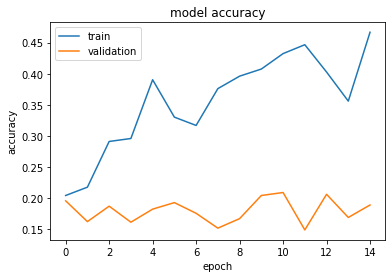

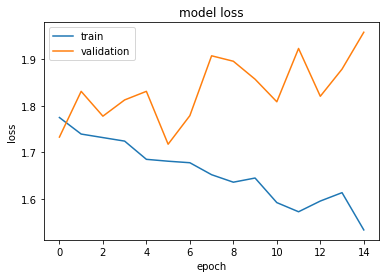

In [22]:
print(historyA.history.keys())
#  "Accuracy"
plt.plot(historyA.history['accuracy'])
plt.plot(historyA.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(historyA.history['loss'])
plt.plot(historyA.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Predicting the Test set results
#y_pred = model.predict(X_test)
#y_pred = (y_pred > 0.5)

# Making the Confusion Matrix
#from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(y_test, y_pred) 

In [23]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_4
1 conv2d_610
2 batch_normalization_610
3 activation_610
4 conv2d_611
5 batch_normalization_611
6 activation_611
7 conv2d_612
8 batch_normalization_612
9 activation_612
10 max_pooling2d_13
11 conv2d_613
12 batch_normalization_613
13 activation_613
14 conv2d_614
15 batch_normalization_614
16 activation_614
17 max_pooling2d_14
18 conv2d_618
19 batch_normalization_618
20 activation_618
21 conv2d_616
22 conv2d_619
23 batch_normalization_616
24 batch_normalization_619
25 activation_616
26 activation_619
27 average_pooling2d_4
28 conv2d_615
29 conv2d_617
30 conv2d_620
31 conv2d_621
32 batch_normalization_615
33 batch_normalization_617
34 batch_normalization_620
35 batch_normalization_621
36 activation_615
37 activation_617
38 activation_620
39 activation_621
40 mixed_5b
41 conv2d_625
42 batch_normalization_625
43 activation_625
44 conv2d_623
45 conv2d_626
46 batch_normalization_623
47 batch_normalization_626
48 activation_623
49 activation_626
50 conv2d_622
51 conv2d_624
52 conv2d_6

In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:700]:
   layer.trainable = False
for layer in model.layers[700:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.05, momentum=0.09), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
historyB = model.fit_generator(train_it, steps_per_epoch=20, epochs=50,
                    initial_epoch=0, validation_data=val_it, validation_steps=10)

Epoch 1/50
20/20 [==============================] - 32s 2s/step - loss: 1.4797 - categorical_accuracy: 0.4763 - val_loss: 1.8332 - val_categorical_accuracy: 0.0894
Epoch 2/50
20/20 [==============================] - 16s 777ms/step - loss: 1.4524 - categorical_accuracy: 0.4938 - val_loss: 1.9435 - val_categorical_accuracy: 0.0861
Epoch 3/50
20/20 [==============================] - 16s 778ms/step - loss: 1.4677 - categorical_accuracy: 0.4763 - val_loss: 1.9125 - val_categorical_accuracy: 0.0927
Epoch 4/50
20/20 [==============================] - 15s 765ms/step - loss: 1.4712 - categorical_accuracy: 0.4778 - val_loss: 1.9122 - val_categorical_accuracy: 0.0845
Epoch 5/50
20/20 [==============================] - 16s 783ms/step - loss: 1.4504 - categorical_accuracy: 0.5016 - val_loss: 1.9315 - val_categorical_accuracy: 0.0861
Epoch 6/50
20/20 [==============================] - 16s 780ms/step - loss: 1.4530 - categorical_accuracy: 0.4968 - val_loss: 1.7844 - val_categorical_accuracy: 0.0927
E

In [29]:
# this is a generator for test data
# test_generator = test_datagen.flow(X_test, y_test)

# let's test our model
accB = model.evaluate_generator(train_it, steps=10,  max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)

10/10 [==============================] - 5s 534ms/step


In [30]:
accB

[1.7887333631515503, 0.18437500298023224]

In [ ]:
print(historyB.history.keys())
#  "Accuracy"
plt.plot(historyB.history['categorical_accuracy'])
plt.plot(historyB.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(historyB.history['loss'])
plt.plot(historyB.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


# Model -- Accuracy (after fine-tuning)

InceptionV3 -- 61

Xception -- 62.5

VGG16 -- 56.25 (reduced from 59.3)

MobileNetV2 -- 